In [9]:
from dotenv import load_dotenv
from langgraph.graph import START, END, StateGraph
from schemas.states import State
from models.nodes_preprocess import keyword_process, generate_relevance, select_top_keywords
from models.nodes_listing import keyword_distribute, generate_title, generate_bp, generate_description
from models.nodes_feedback import user_input, parse_user_feedback, print_feedback
from graph.router import status_router, feedback_router

load_dotenv()


def build_graph():
    builder = StateGraph(State)
    
    # 키워드 분배
    builder.add_sequence([keyword_process, generate_relevance, select_top_keywords])

    # 초안 작성
    builder.add_edge("select_top_keywords", "keyword_distribute")
    builder.add_sequence([keyword_distribute, generate_title, generate_bp, generate_description])

    # 사용자 피드백
    builder.add_node('user_input', user_input)
    builder.add_node('parse_user_feedback', parse_user_feedback)
    builder.add_node('print_feedback', print_feedback)

    # 재생성 노드
    builder.add_node('regenerate_title', generate_title)
    builder.add_node('regenerate_bp', generate_bp)
    builder.add_node('regenerate_description', generate_description)
    
    # 에지
    builder.add_edge(START, "keyword_process")
    
    builder.add_edge('generate_description', 'user_input')
    
    builder.add_conditional_edges(
        'user_input',
        status_router,
        {
            'parse_user_feedback': 'parse_user_feedback',
            'END': END
        }
    )
    
    builder.add_edge('parse_user_feedback', 'print_feedback')
    
    builder.add_conditional_edges(
        'print_feedback',
        feedback_router,
        {
            'regenerate_title': 'regenerate_title',
            'regenerate_bp': 'regenerate_bp',
            'regenerate_description': 'regenerate_description'
        }
        
    )
    
    builder.add_edge('regenerate_title', 'print_feedback')
    builder.add_edge('regenerate_bp', 'print_feedback')
    builder.add_edge('regenerate_description', 'print_feedback')    
    
    
    return builder.compile()

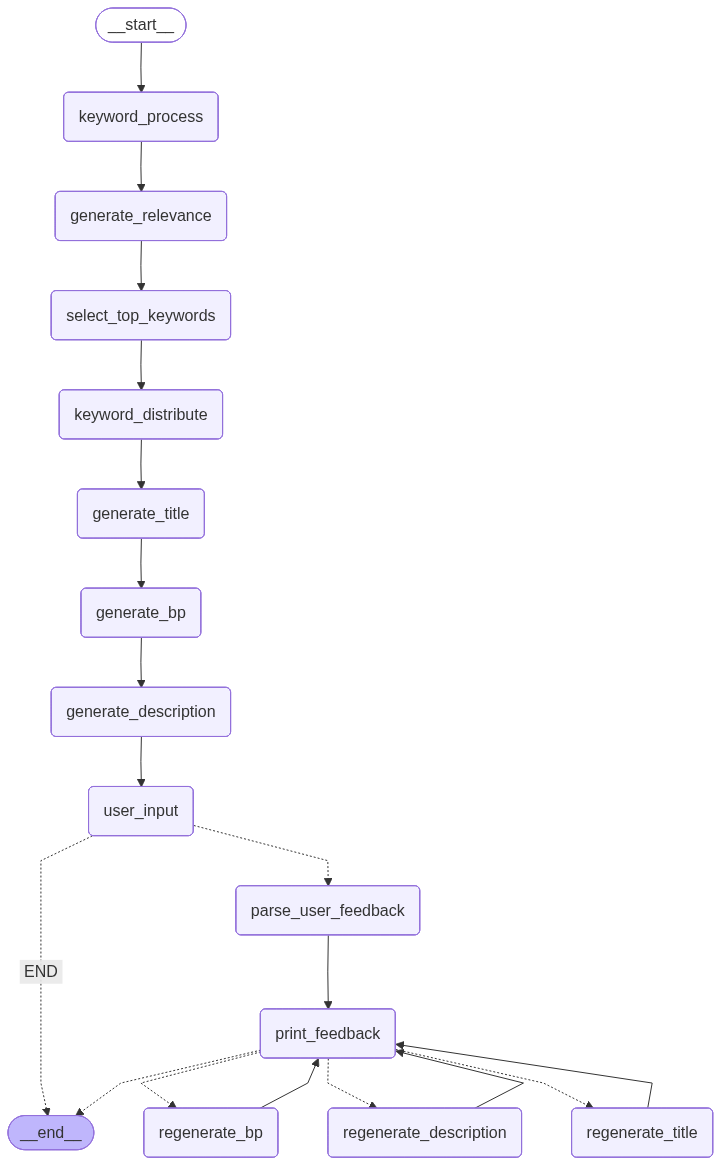

In [10]:
graph = build_graph()

from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())